# Practical 5: Spatial operations

So far, the practicals have been introducing you to some of the key concepts of spatial data and some of the basic steps of properly handling things like CRS and measuring distance. This practical will start to shift more to providing you with a set of "tools" and when you might want to use them for analyses. This practical will cover topics in spatial operations that will involve geometric manipulations as well as (and in combination with) non-spatial data operations. 

Rather than dealing with relatively simple datasets as in the earlier practicals, this practical will also introduce a set of real-world datasets that you will be working with for the remainder of the workshop. This will give you some practice with a real workflow of loading, cleaning, joining up datasets. 

The objectives of this lesson are to:
* understand different overlay operations and spatial relationships
* carry out gemetric manipulations such as creating buffers, centroids, intersections
* be able to join, select, aggregate, and dissolve GeoDataFrames
* start creating more sophisticated maps and plots


In [1]:
# load the package
import geopandas as gpd
import matplotlib.pyplot as plt

## Southampton datasets

I have assembled a few interesting datasets for Southampton (we won't use all in this practical). The data are located in the `/data` directory of the workshop materials folder. These files inclulde:
* locations of fast food restaurants, convenience stores, and supermarkets
* an [index of local deprivation](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019)
* census boundaries and data on recent population

## Loading data

Let's start by loading a dataset of census "Output Areas" (OAs). The OA is the smallest unit of population geography for the census in the UK. I've already created a subset of the national dataset. This will define our Southampton study area.

In this practical we're going to look at the number of local supermarkets and the distance people have to travel to a supermarket.

In [2]:
# load output areas
oa = gpd.read_file('../data/soton_OA_2011.gpkg')

oa.shape

(766, 4)

In [3]:
oa.head()

,code,label,name,geometry
0,E00086549,E06000045E02003571E01017136E00086549,None,"MULTIPOLYGON (((441446.000 112445.000, 441445...."
1,E00086575,E06000045E02003571E01017136E00086575,None,"MULTIPOLYGON (((441695.441 112825.239, 441694...."
2,E00086576,E06000045E02003571E01017137E00086576,None,"MULTIPOLYGON (((441632.370 112875.041, 441631...."
3,E00086578,E06000045E02003571E01017140E00086578,None,"MULTIPOLYGON (((441453.996 112628.964, 441457...."
4,E00086579,E06000045E02003571E01017136E00086579,None,"MULTIPOLYGON (((441590.962 112702.404, 441591...."


<AxesSubplot:>

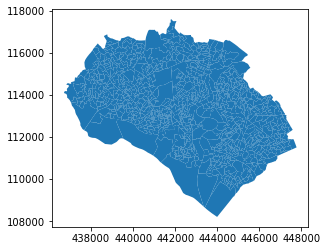

In [4]:
oa.plot()

Next we'll use data on local supermarkets. These data come from [OpenStreetMap](https://www.openstreetmap.org) and I've converted the GeoJSON files to GeoPackages. The data suffer from some errors, omissions, and gaps in information common with *volunteered geographic information*. 

For instance, these data come in two different representations: some stores are points and others are polygons. We will need to convert and combine these files before continuing with the analyses

As a side note, a good tool in Python for extract OSM data is [OSMnx](https://github.com/gboeing/osmnx).

In [5]:
# load supermarket points
smkt_pts = gpd.read_file('../data/supermarket_pts.gpkg')

smkt_pts.head()

,id,@id,addr:city,addr:country,addr:housenumber,addr:postcode,addr:state,addr:street,brand,brand:wikidata,...,start_date,building:part,indoor,old_name,smoking,source:fhrs_ref,fhrs:local_authority_id,name:en,last_checked,geometry
0,node/94952771,node/94952771,Havant,None,12-22,PO9 1PR,None,North Street,Waitrose,Q771734,...,None,None,None,None,None,None,None,None,None,POINT (-0.98124 50.85211)
1,node/297021458,node/297021458,Portsmouth,GB,None,PO6 1RR,None,Fitzherbert Road,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-1.03962 50.84051)
2,node/300149741,node/300149741,Southampton,GB,117,SO14 2EA,None,High Street,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-1.40416 50.89806)
3,node/360679076,node/360679076,Portsmouth,GB,48,PO6 2NE,None,Tregaron Avenue,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-1.05400 50.84285)
4,node/360980083,node/360980083,Portsmouth,GB,None,PO1 2LX,None,Winston Churchill Avenue,Co-op Food,Q3277439,...,None,None,None,None,None,None,None,None,None,POINT (-1.09184 50.79520)


<AxesSubplot:>

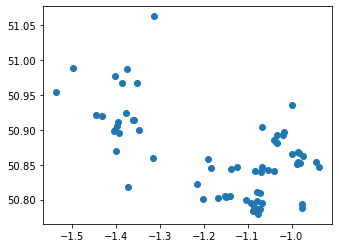

In [6]:
smkt_pts.plot()

In [7]:
# load supermarket polygons
smkt_ply = gpd.read_file('../data/supermarket_poly.gpkg')

smkt_ply.head()

,id,@id,addr:city,addr:country,addr:housenumber,addr:postcode,addr:state,addr:street,brand,brand:wikidata,...,start_date,building:part,indoor,old_name,smoking,source:fhrs_ref,fhrs:local_authority_id,name:en,last_checked,geometry
0,relation/9362640,relation/9362640,Fareham,GB,208-220,PO16 0AL,Hampshire,West Street,Aldi,Q125054,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-1.18729 50.85251, -1.18766 50.85253..."
1,way/5117252,way/5117252,Waterlooville,None,None,PO8 9FB,None,Lakesmere Road,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-1.00204 50.90853, -1.00204 50.90823..."
2,way/5124312,way/5124312,"Bedhampton, Havant",GB,None,PO9 3QW,None,Larchwood Avenue,Asda,Q297410,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-1.01529 50.86315, -1.01547 50.86314..."
3,way/10522631,way/10522631,Southampton,GB,None,SO14 7EG,None,Portland Terrace,Asda,Q297410,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-1.40829 50.90601, -1.40827 50.90599..."
4,way/23134411,way/23134411,Southampton,GB,None,SO40 3ZA,None,Maynard Road,Asda,Q297410,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-1.48858 50.91840, -1.48863 50.91838..."


<AxesSubplot:>

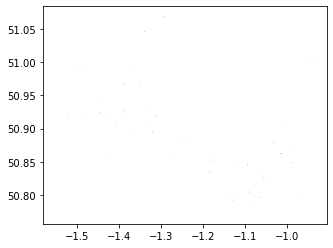

In [8]:
smkt_ply.plot()  # note: the polygons are just really small

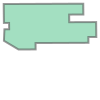

In [9]:
smkt_ply.geometry[1]

### Consistent projections

As we have seen in several practicals now, we need to consider the Coordinate Reference System when we're working with different datasets. Before we can combine the files, let's make sure the supermarket data align with the OA census data.

In [10]:
# CRS of output areas
oa.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [11]:
# CRS of supermarkets
print(smkt_pts.crs)
print(smkt_ply.crs)

epsg:4326
epsg:4326


Both of the OSM files of supermarkets are in WGS84 (EPSG:4326). We are going to project these to OSGB 1936. That projected coordinate system will help us make more accurate distance calculations in later steps of this analysis.

In [12]:
# project supermarkets
smkt_pts_prj = smkt_pts.to_crs(oa.crs)
smkt_ply_prj = smkt_ply.to_crs(oa.crs)

Now that we are using the same CRS, we can easily plot the data on the same map.

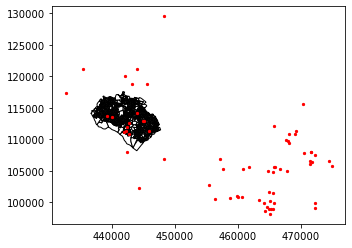

In [13]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

# plot the outlines of the output areas
oa.plot(ax=ax, color='white', edgecolor='black')

# add just the supermarket points
smkt_pts_prj.plot(ax=ax, marker='o', color='red', markersize=5)

plt.show()

Notice in the plot above that the points are well outside of just Southampton (including Portsmouth!). I downloaded a larger area. We'll next extract the data down for just our study area.

### Extracting Soton data

An easy way to extract spatial data for only a specific region of interest is to use the `clip` function in `GeoPandas`. Clip will modify the geometry of the object being "clipped". In this instance, we will want to clip the supermarkets by the geometry of the OAs to create a new supermarket dataset for only Southampton locations.

For more information on this operation, see here: [https://geopandas.org/gallery/plot_clip.html](https://geopandas.org/gallery/plot_clip.html)

But we need need to consider some of the effects of reducing our study area. Restricting our supermarkets to only those within the OA boundaries could create what are known as **edge effects** in our study. The OAs on the edge of the study area may appear to have higher distances to supermarkets because we've limited our options to only those inside the city area. We'll avoid (some) of the edge effects of clipping, by first creating a spatial buffer.

### Buffering and clipping

Buffering and clipping spatial data are two of the most fundamental operations. These derive from `shapely` and you can find more information here: [https://geopandas.org/geometric_manipulations.html](https://geopandas.org/geometric_manipulations.html).

Let's start with just a simple buffer example to illustrate the idea.

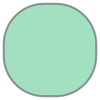

In [14]:
from shapely.geometry import Polygon
from descartes import PolygonPatch

# create a geometry with a simple location
p = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])

# buffer to creat a rounded rectangle
p.buffer(3.5)

For Southampton, we're going to use the OAs and buffer them by 1000 meters. But there are multiple polygons in that GeoDataFrame. Let's first simplify it by using another geometric operation - the **union** of the geometries.

In [15]:
# combine all the OA shapes - we'll do this and create a new `GeoDataFrame`
# buffer by 1km (note: units defined by the CRS)
oa_buffer = gpd.GeoDataFrame({
                              'id':[1],
                              'geometry': oa.unary_union.buffer(1000) # combining these operations into 1 step
                             }, crs="EPSG:27700") # remember to define the CRS

<AxesSubplot:>

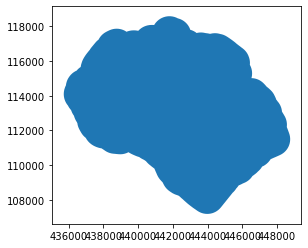

In [16]:
# plot
oa_buffer.plot()

Having completed these preparations, now we can clip the supermarkets and move on to combining them.

In [17]:
# clipping step
smkt_pts_soton = gpd.clip(smkt_pts_prj, oa_buffer)
smkt_ply_soton = gpd.clip(smkt_ply_prj, oa_buffer)

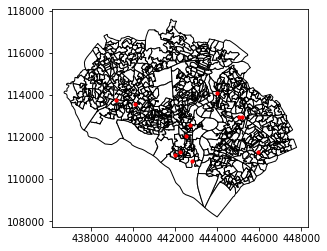

In [18]:
# repeat the plot to see the results of the clipping
fig, ax = plt.subplots()
ax.set_aspect('equal')

# plot the outlines of the output areas
oa.plot(ax=ax, color='white', edgecolor='black')

# add just the supermarket points
smkt_pts_soton.plot(ax=ax, marker='o', color='red', markersize=10)

plt.show()

We could have subset the supermarkets by their city attribute (`== 'Southampton'`), but here we're showing you a geographical approach. You can't subset the data and include a buffer to avoid edge effects using only the attributes in the data.

## Cleaning and combining files

The next step in our pre-processing workflow is to combine the supermarket points and polygons into a single file. We want to: 1) convert the polygons to a point represenation, and then 2) combine the two point `GeoDataFrames` into a single object that we can work with.

To convert from polygons to points, we will use each polygon's **centroid** location. The centroid is the geometric center of the shape. If our polygons have strange and complicated shapes, holes or have multipolygon pieces, we can still calculate a centroid, but sometimes it won't be contained by the original polygon. Just be aware of this fact. It won't affect our analyses.

In `GeoPandas` the centroid is exposed as a basic method for all data frames with `.centroid`. This returns a `GeoSeries` which we can use to assign to the geometry.

In [19]:
# create centroids of supermarkets
# assign them to the geometry (overwrite the polygons!)
smkt_ply_soton.geometry = smkt_ply_soton.centroid

In [20]:
# all points now
smkt_ply_soton.geometry.head()

3     POINT (441762.897 111993.517)
4     POINT (436069.223 113305.256)
5     POINT (443744.604 110841.097)
13    POINT (447888.097 110806.740)
19    POINT (442636.674 114052.102)
Name: geometry, dtype: geometry

Now that we have two point-geometry files of supermarket locations, we want to combine them into a single object. We will do this using an `append` command that comes from `Pandas`. This is a simple command to execute because we've already done the careful preprocessing to make sure the CRS are the same.

In [21]:
# create a unified supermarket dataset
smkts = smkt_pts_soton.append(smkt_ply_soton)

smkts.shape

(42, 80)

In [22]:
# original data size
[smkt_pts_soton.shape, smkt_ply_soton.shape]

[(11, 80), (31, 80)]

<AxesSubplot:>

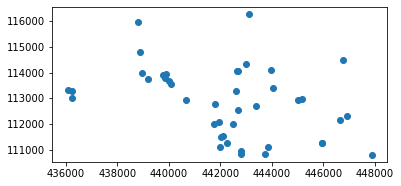

In [23]:
smkts.plot()

In [24]:
smkts.head()

,id,@id,addr:city,addr:country,addr:housenumber,addr:postcode,addr:state,addr:street,brand,brand:wikidata,...,start_date,building:part,indoor,old_name,smoking,source:fhrs_ref,fhrs:local_authority_id,name:en,last_checked,geometry
2,node/300149741,node/300149741,Southampton,GB,117,SO14 2EA,None,High Street,None,None,...,None,None,None,None,None,None,None,None,None,POINT (441998.254 111123.555)
10,node/638921542,node/638921542,Southampton,GB,"412,414",SO18 5RS,None,Bitterne Road,None,None,...,None,None,None,None,None,None,None,None,None,POINT (445032.039 112945.309)
20,node/1556159256,node/1556159256,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (442498.341 112020.586)
22,node/2029179283,node/2029179283,Southampton,GB,17,SO18 1NN,None,Manor Farm Road,None,None,...,None,None,None,None,None,None,None,None,None,POINT (443974.650 114097.267)
53,node/5007213122,node/5007213122,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,International Foods,None,POINT (442693.707 112561.000)


#### Save your work

Let's save the file we've created so that we can use it in later practicals. Remember, you may need to adjust the file paths depending on how you're running this notebook.

In [25]:
# output
smkts.to_file('../data/soton_smkts.gpkg', driver='GPKG')

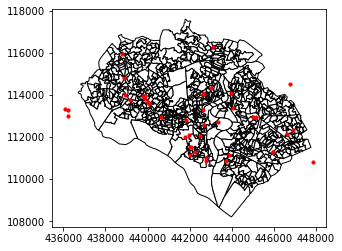

In [26]:
# recreate our basic data plot with the new dataset
fig, ax = plt.subplots()
ax.set_aspect('equal')

# plot the outlines of the output areas
oa.plot(ax=ax, color='white', edgecolor='black')

# add just the supermarket points
smkts.plot(ax=ax, marker='o', color='red', markersize=10)

plt.show()

## Analysis using Point-in-Polygon

Everything we've done thus far has been data preparation and cleaning. We can finally start to analyse our data!

Our first question is relatively simple to phrase: *how many supermarkets are there in an area?*

For this analysis we will first use the OA boundaries. Then we will look at how we might summarise the results at different geographic scales.

### Using a 'spatial join'

There are several ways we might answer this question, but we'll use this as an opportunity to look at the *spatial join* in more detail. A spatial join is a way to merge information based on geometric overlays. You can assign or combine information based on what is contained or intersects another geographic shape. A *spatial* join is similar, conceptually, to a *non*-spatial join that you may be familiar with from `pandas` or other SQL-type operations.

In `GeoPandas` these operations are carried out using `.sjoin`. The documentation ([here](https://geopandas.org/mergingdata.html?highlight=spatial%20join#sjoin-arguments)) explains that it takes two important arguments:
* `op`: specifying the geometry operation as intersects, within, contains
* `how`: defining the join as left, right, or inner

In [27]:
# create a spatial join of points within polygons
# store in a new GeoDataFrame
oa_sj = gpd.sjoin(oa, 
                  smkts, 
                  how='inner' 
                 )

In [28]:
oa_sj.head()

,code,label,name_left,geometry,index_right,id,@id,addr:city,addr:country,addr:housenumber,...,opening_hours:post_office,start_date,building:part,indoor,old_name,smoking,source:fhrs_ref,fhrs:local_authority_id,name:en,last_checked
7,E00086586,E06000045E02003571E01017140E00086586,None,"MULTIPOLYGON (((442164.000 112519.545, 442164....",3,way/10522631,way/10522631,Southampton,GB,None,...,None,None,None,None,None,None,None,None,None,None
7,E00086586,E06000045E02003571E01017140E00086586,None,"MULTIPOLYGON (((442164.000 112519.545, 442164....",76,way/358349121,way/358349121,Southampton,None,123,...,None,None,None,None,None,None,None,None,None,None
8,E00166958,E06000045E02003571E01017137E00166958,None,"MULTIPOLYGON (((441782.607 112933.667, 441784....",59,way/195012237,way/195012237,Southampton,None,71,...,None,None,None,None,None,None,None,None,None,None
32,E00086557,E06000045E02003571E01017140E00086557,None,"MULTIPOLYGON (((442147.000 111489.000, 442146....",44,way/153484861,way/153484861,Southampton,GB,15-17,...,None,None,None,None,None,None,None,None,None,None
32,E00086557,E06000045E02003571E01017140E00086557,None,"MULTIPOLYGON (((442147.000 111489.000, 442146....",43,way/153484342,way/153484342,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [29]:
oa_sj.shape

(37, 84)

In [30]:
oa.shape

(766, 4)

Notice how there are now fewer records in the spatially joined data frame. That's because we used an 'inner' join. Any polygon that doesn't have a point is dropped. If we had used a 'left' join then the polygons would have been duiplicated when the contain more than one point and polygons with zero points would have been kept.

We can use some `pandas` techniques to aggregate and count the records based on their unique OA code.

In [31]:
# count the number of points per unique OA (identified by the attribute [code])
smkt_count = oa_sj.groupby('code').code.count()

smkt_count.head()

code
E00086557    2
E00086564    1
E00086586    2
E00086649    1
E00086652    1
Name: code, dtype: int64

### Using a non-spatial join

To add the the summarised counts of supermarkets back into our original `GeoDataFrame`, we will use a type of non-spatial join operation to *merge* the data. In this operation, notice that we're merging non-spatial data with spatial data, but the `GeoDataFrame` is still recognised.

In [32]:
# join counts to the OAs and store in a new object
# note that we use 'right_index' because we don't have a separate attribute column, just the index
oa_smkt_count = oa.merge(smkt_count.to_frame('smkt_count'), # create a column label
                         how='left',  # keep all the OA records
                         left_on='code',
                         right_index=True
                        )

In [33]:
# show the result. Most NAs where there were no points.
oa_smkt_count[['code','smkt_count']]

,code,smkt_count
0,E00086549,NaN
1,E00086575,NaN
2,E00086576,NaN
3,E00086578,NaN
4,E00086579,NaN
...,...,...
761,E00166981,NaN
762,E00166982,NaN
763,E00166998,NaN
764,E00087214,NaN


### Viewing the results

We can create a simple **choropleth** map by specifying the column of data in the `.plot()` call.

<AxesSubplot:>

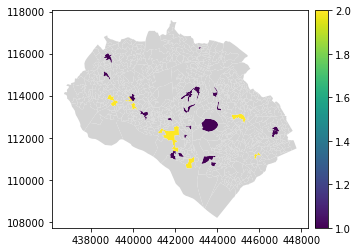

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# create a plot of the count of points by OA
fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

# make the legend line up with the size of the plot
cax = divider.append_axes("right", size="5%", pad=0.1)

oa_smkt_count.plot(column='smkt_count', 
                   ax=ax, 
                   legend=True, 
                   cax=cax,
                   missing_kwds={'color': 'lightgrey'})

## Dissolving to aggregate data

The output areas are really too small for this analysis to be useful. Most of the results show that zero supermarkets in the OA. However, census data in the UK are built on a hierarchy of geometries. Ouput areas combine into larger units called "Lower Super Output Areas" or LSOAs. 

We're going to create a LSOAs dataset from our OAs by extracting the LSOA identifier, and then *dissolving* the OAs to create a new, aggregated dataset. This gives us a chance to practice a few other data processing and spatial operations.

Dissolving is a very useful operation because it allows you summarise both spatial and non-spatial information. It's like performing a union on the geometries while also performing an aggergate function on the attribute columns. This is described in more detail [here](https://geopandas.org/aggregation_with_dissolve.html).

In [35]:
# remember what format we have
oa_smkt_count.head()

,code,label,name,geometry,smkt_count
0,E00086549,E06000045E02003571E01017136E00086549,None,"MULTIPOLYGON (((441446.000 112445.000, 441445....",NaN
1,E00086575,E06000045E02003571E01017136E00086575,None,"MULTIPOLYGON (((441695.441 112825.239, 441694....",NaN
2,E00086576,E06000045E02003571E01017137E00086576,None,"MULTIPOLYGON (((441632.370 112875.041, 441631....",NaN
3,E00086578,E06000045E02003571E01017140E00086578,None,"MULTIPOLYGON (((441453.996 112628.964, 441457....",NaN
4,E00086579,E06000045E02003571E01017136E00086579,None,"MULTIPOLYGON (((441590.962 112702.404, 441591....",NaN


In [36]:
# create a new identifier column of LSOA codes from the OA codes
# use `pandas` functions to slice the string and create a new column
oa_smkt_count['lsoa'] = oa_smkt_count['label'].str.slice(start=18, stop=27)

In [37]:
oa_smkt_count.head()

,code,label,name,geometry,smkt_count,lsoa
0,E00086549,E06000045E02003571E01017136E00086549,None,"MULTIPOLYGON (((441446.000 112445.000, 441445....",NaN,E01017136
1,E00086575,E06000045E02003571E01017136E00086575,None,"MULTIPOLYGON (((441695.441 112825.239, 441694....",NaN,E01017136
2,E00086576,E06000045E02003571E01017137E00086576,None,"MULTIPOLYGON (((441632.370 112875.041, 441631....",NaN,E01017137
3,E00086578,E06000045E02003571E01017140E00086578,None,"MULTIPOLYGON (((441453.996 112628.964, 441457....",NaN,E01017140
4,E00086579,E06000045E02003571E01017136E00086579,None,"MULTIPOLYGON (((441590.962 112702.404, 441591....",NaN,E01017136


With this new identifier `[lsoa]` we can use it create a new set of geometries. In the same step, we can aggregate our variable of interest (the count of supermarkets) and create a new data set.

In [38]:
# `dissolve` the OA data to create LSOA boundaries
# sum the count of supermarkets within the new areas
lsoa_smkt_count = oa_smkt_count[['lsoa','smkt_count','geometry']].dissolve(by='lsoa', aggfunc='sum')

In [39]:
lsoa_smkt_count.head()

,geometry,smkt_count
lsoa,,
E01017136,"POLYGON ((441876.774 112587.161, 441877.875 11...",0.0
E01017137,"POLYGON ((441632.370 112875.041, 441631.994 11...",1.0
E01017138,"POLYGON ((441307.700 112577.580, 441308.208 11...",0.0
E01017139,"POLYGON ((442373.000 111482.000, 442372.963 11...",1.0
E01017140,"POLYGON ((441981.000 111652.000, 441980.000 11...",4.0


Notice that by dissolving we're left with values of 0.0 instead of `Nan`.

In [40]:
lsoa_smkt_count.shape

(148, 2)

### Viewing the results (2)

Let's create another plot of the LSOA results. We'll continue to use the defaul colour schemes for now, but we'll soon look at how to improve on them.

<AxesSubplot:>

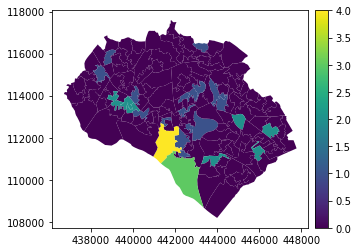

In [41]:
# create a plot of the count of points by LSOA
fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

# make the legend line up with the size of the plot
cax = divider.append_axes("right", size="5%", pad=0.1)

lsoa_smkt_count.plot(column='smkt_count', 
                     ax=ax, 
                     legend=True, 
                     cax=cax)

We've now answered our first question - we have both a map and a table of the number of supermarkets in each area of Southampton. It seems like the stores are very clustered. Some places have three or four markets, while most others have none.

To answer this question we've done spatial and non-spatial joins, aggegated data, and dissolved geographic data.

## Distance calculations (returned)

For our next analysis, let's return to our last practical and revisit distance calculations. 

In this next section we aim to answer: *how far do people have to travel to reach a supermarket?*

Luckily our data are already cleaned, merged, and ready for analysis. We need to think a bit more about how we define "distance" given our data. We have polygon representations of census areas. That's typically the kind of data you'll work with, but it's not ideal. It doesn't give you very high *resolution* of where people exactly live. Also, when we measure distances between polygons, the default behaviour is to measure from the closest border point. An oddly shaped polygon could give you strange results in that case.

So we are going to have to approximate the average travel distance for all households within a census area.

Note, for this analysis, let's continue to use LSOAs rather than the smaller OAs.

### Creating centroids

We've already seen one potential solution for addressing the issue of measuring distances and polygon edges - we can change the geometry representation of LSOAs from a polygon to its centroid point. This is a common approximation when working with (relatively) small geographic areas. 

In [42]:
# convert lsoa to centroid points
# store this as a separate `GeoSeries`. We don't need a full DataFrame
lsoa_pts = lsoa_smkt_count.centroid

lsoa_pts.head()

lsoa
E01017136    POINT (441694.718 112557.561)
E01017137    POINT (441535.322 112799.523)
E01017138    POINT (441452.579 112912.476)
E01017139    POINT (442294.148 111880.098)
E01017140    POINT (441569.706 111723.863)
dtype: geometry

This step simplifies our analysis problem considerably. Now we to have measure the distance between sets of points, which we did in the previous practical!

### Nearest supermarket

For each LSOA area, find the distance to the nearest supermarket. Remember that our CRS is already projected (we're using EPSG 27700), so it's appropriate to use Euclidean distances.

In [43]:
# calculate the distance from LSOA centroids to supermarkets
# use a unary union to combine supermarket locations and find the nearest distance
lsoa_smkt_count['smkt_dist'] = lsoa_pts.distance(smkts.unary_union)

In [44]:
lsoa_smkt_count.head()

,geometry,smkt_count,smkt_dist
lsoa,,,
E01017136,"POLYGON ((441876.774 112587.161, 441877.875 11...",0.0,257.280417
E01017137,"POLYGON ((441632.370 112875.041, 441631.994 11...",1.0,269.526033
E01017138,"POLYGON ((441307.700 112577.580, 441308.208 11...",0.0,372.747407
E01017139,"POLYGON ((442373.000 111482.000, 442372.963 11...",1.0,247.854310
E01017140,"POLYGON ((441981.000 111652.000, 441980.000 11...",4.0,331.716277


We added our results our calculation back to the original LSOA polygon dataset

<AxesSubplot:>

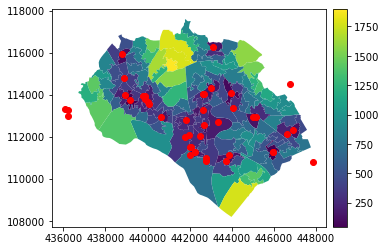

In [45]:
# create a plot of the distance to supermarkets by LSOA
fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

# make the legend line up with the size of the plot
cax = divider.append_axes("right", size="5%", pad=0.1)

lsoa_smkt_count.plot(column='smkt_dist', 
                     ax=ax, 
                     legend=True, 
                     cax=cax)

# add the locations of supermarkets
smkts.plot(ax=ax, color='red')

### Save your work

We'll return to this LSOA dataset in later exercises, so go ahead and save this file. Remember that you may need to update the file paths in the code shown below, depending on how you're running this notebook.

In [46]:
# write out GeoDataFrame to GeoPackage file
lsoa_smkt_count.to_file('../data/soton_lsoa_distance.gpkg', driver='GPKG')

## Choropleth maps

It's time to start improving our maps. We've been using the default parameters and they've been working OK, but the distance calculations give us an opportunity to explore some other mapping techniques, particularly how we categorise data in the legend.

Don't worry this is just a warm-up, the next practicals will be all about geovisualisations.

### Colour maps

As mentioned before, the `plot()` method in `GeoPandas` relies on `matplotlib`. This allows us to make use of many of those features and extensions. This includes [colourmaps](https://matplotlib.org/tutorials/colors/colormaps.html).)

Let's change our map to use a colour gradient

<AxesSubplot:>

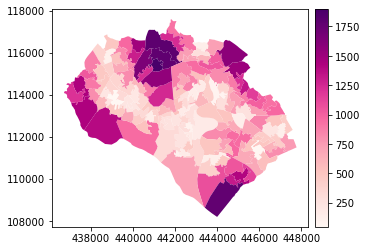

In [47]:
fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

# make the legend line up with the size of the plot
cax = divider.append_axes("right", size="5%", pad=0.1)

lsoa_smkt_count.plot(column='smkt_dist', 
                     ax=ax, 
                     cmap='RdPu',  # THIS is the new part
                     legend=True, 
                     cax=cax)

### Data bins

Rather than letting `.plot()` decide how to assign colours to data and treating it as continuous, let's take a little control and plot the LSOA by quintile of distance values.

This step will start using `mapclassify` and the documentation and examples can be found on the website: [https://pysal.org/mapclassify/index.html](https://pysal.org/mapclassify/index.html).

<AxesSubplot:>

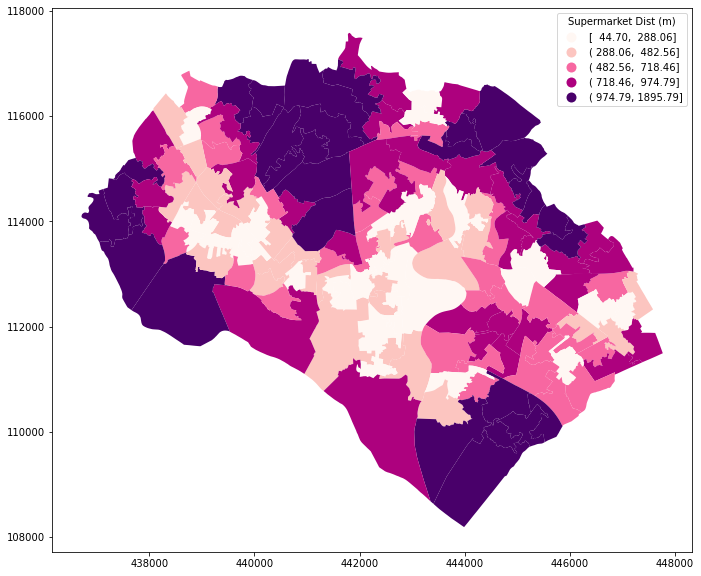

In [48]:
lsoa_smkt_count.plot(column='smkt_dist', 
                     cmap='RdPu', 
                     scheme='Quantiles', # THIS is new
                     k=5, # THIS define the number of groups, 5=quintiles
                     legend=True,
                     legend_kwds={'title':"Supermarket Dist (m)"}, # add a name
                     figsize=(15,10) # adjust the size so the legend doesn't overlap
                    )

## Extra challenges

In the exercise above, we used a buffer to extract the locations of supermarkets for our study area. Buffers are also useful for quickly querying data within a defined distance. Test this idea by selecting the `lsoa_pts` data which are within 1 km of a supermarket using a buffer around the `smkts` points data. Compare the results to your `GeoDataFrame` with the measured distances and see if it agrees.

Hint: to select you can use `.clip` again, or try one of the other overlay relationships, such as [within](https://geopandas.org/reference.html).

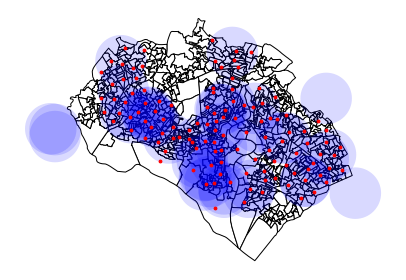

In [49]:
# test your code here


# Create data frame which has polygons of 1km radii to supermarkets
smkts_buffer = smkts.geometry.buffer(1000)
# Overlap of lsoa centroids with supermarket buffers
lsoa_near_smkt = gpd.clip(lsoa_pts, smkts_buffer)

# Plot to ensure correct overlap
fig, ax = plt.subplots(1, 1)

oa.plot(ax=ax, color='white', edgecolor='black')
smkts_buffer.plot(ax=ax, color='blue', alpha=.15)
lsoa_near_smkt.plot(ax=ax, color='red', markersize=8)
ax.set_axis_off()
fig.tight_layout()

Buffers can also have varying sizes. Try passing a series of values to the distances argument of `.buffer(distance=ZZZ)` and plotting the results.

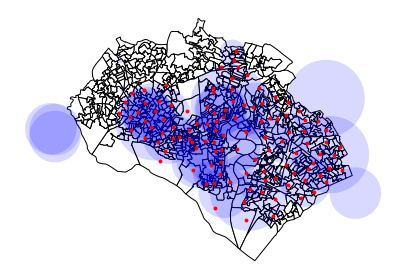

In [50]:
# Test area
# create an attribute holding random buffer size values
import numpy as np
smkts['b'] = np.random.choice([100, 300, 500, 1000, 1500], size=smkts.shape[0])

# now add the code to buffer
smkts_buffer = smkts.geometry.buffer(smkts.b)
# plot these data
# Overlap of lsoa centroids with supermarket buffers
lsoa_near_smkt = gpd.clip(lsoa_pts, smkts_buffer)

# Ensure correct overlap
fig, ax = plt.subplots(1, 1)

oa.plot(ax=ax, color='white', edgecolor='black')
smkts_buffer.plot(ax=ax, color='blue', alpha=.15)
lsoa_near_smkt.plot(ax=ax, color='red', markersize=8)
ax.set_axis_off()
fig.tight_layout()

Finished! Well done!